In [1]:
#install libraries

#pip install sentence-transformers
#pip install umap-learn
#pip install hdbscan

In [2]:
#import libraries

import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#reads in california constitution
with open('CAConstitution.txt', 'r') as f:
    CAdata = f.read()

In [4]:
#reads in hawaii constitution
with open('HIConstitution.txt', 'r') as f:
    HIdata = f.read()

In [5]:
#reads in maryland constitution
#with open('MDConstitution.txt', 'r') as f:
    #MDdata = f.read()

In [6]:
#reads in oregon constitution
with open('ORConstitution.txt', 'r') as f:
    ORdata = f.read()

In [7]:
#reads in texas constitution
with open('TXConstitution.txt', 'r') as f:
    TXdata = f.read()

In [14]:
data = CAdata

In [15]:
#data cleaning

#Removes roman numerals from data
def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, ' ', text)

data = clean(data)

In [16]:
#Removes all numbers
data = ''.join([i for i in data if not i.isdigit()])

In [17]:
#splits on nelwine
data = data.split("\n")    

In [18]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/356 [00:00<?, ?it/s]

In [19]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

In [20]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

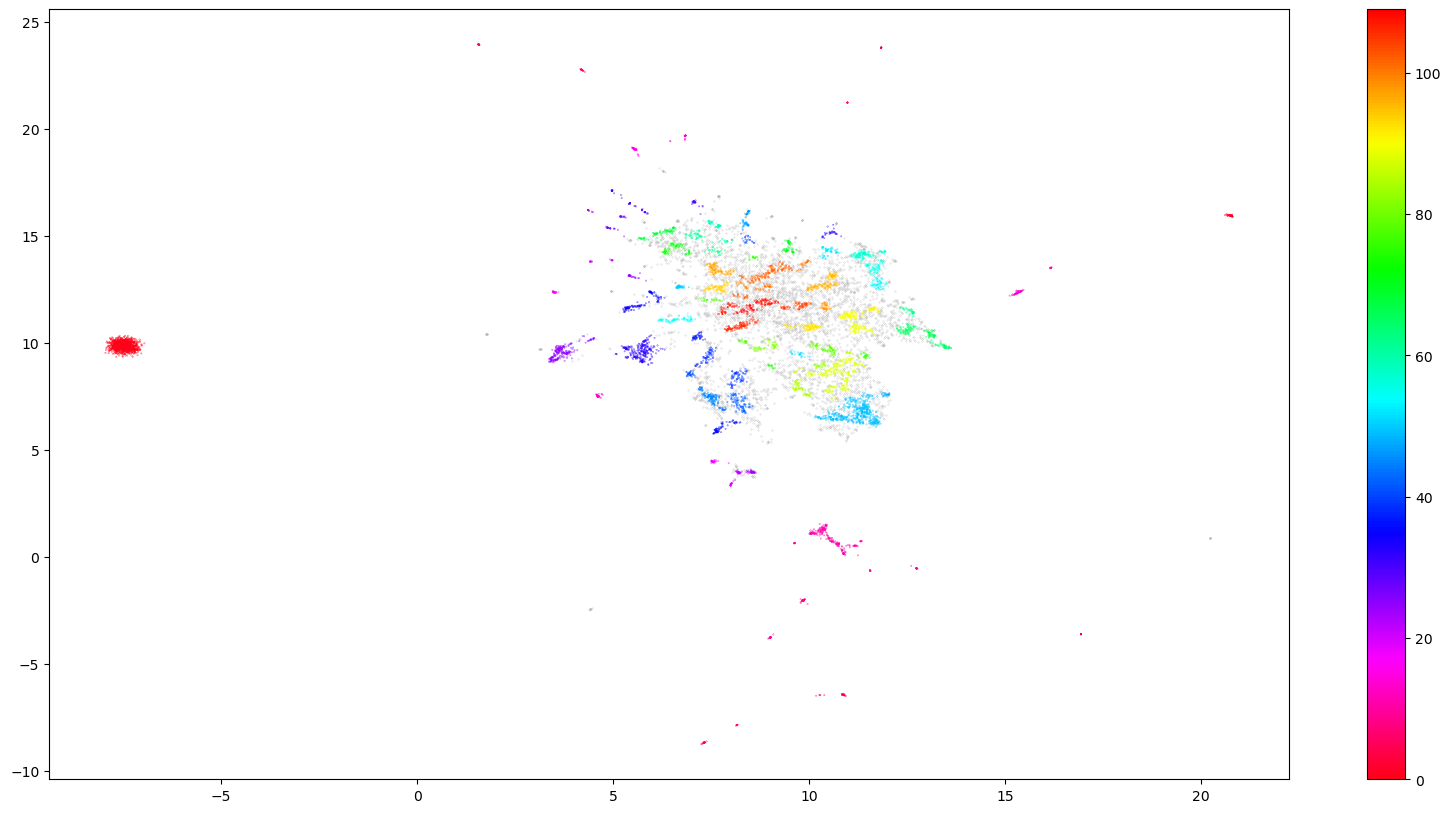

In [21]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x','y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [22]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [23]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [24]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/var/folders/8z/5tmywm6s11d187fc5fg_fgb80000gn/T/ipykernel_29238/3267578824.py:5: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)


In [25]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,4028
1,0,953
50,49,543
33,32,264
89,88,255
12,11,251
26,25,202
103,102,163
58,57,128
46,45,123


In [28]:
#update with the top 5 indices from the table above
index = [1, 50, 33, 89, 12]

In [33]:
for i in index:
    print("Topic #", i-1)
    print(top_n_words[i][:6])
    print()

Topic # 0
[('repealed', 1.2999541358822362), ('november', 1.049208770238919), ('sec', 0.9831267703414249), ('zoning', 0.0), ('exacted', 0.0), ('evasion', 0.0)]

Topic # 49
[('spouse', 0.5796679907140893), ('transfers', 0.33290155149015416), ('grandchildren', 0.24179542510561744), ('property', 0.2197714625735034), ('deceased', 0.2072532215191007), ('veteran', 0.200207022595337)]

Topic # 32
[('trees', 0.36859822362494515), ('forest', 0.34003414948731836), ('timber', 0.2962653132608191), ('agricultural', 0.23929784433931495), ('crops', 0.16227851745816355), ('planted', 0.15772456743134292)]

Topic # 88
[('governor', 0.5398255864374794), ('lieutenant', 0.1557948298071702), ('legislature', 0.11711729318577924), ('appointed', 0.08241074628381874), ('shall', 0.08008782266738029), ('office', 0.07709461690439183)]

Topic # 11
[('june', 2.256101417075472), ('opted', 0.7258500174890069), ('negative', 0.2515394082447283), ('section', 0.24341944589853065), ('balance', 0.2257664119702789), ('includ

In [34]:
len(topic_sizes)

111